In [63]:
#Importing packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import datetime
import seaborn as sns
import math

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import requests # library to handle requests

print("Libraries imported!")

Libraries imported!


In [2]:
df = pd.read_csv('cleaned_data.csv', index_col=0)
print(df.shape)
df.head()

(65796, 18)


,Name,Mileage,Address,Rating,Fuel Type,City MPG,Highway MPG,Drivetrain,Engine,Exterior Color,Interior Color,Transmission,Num_ent_features,Num_safe_features,Price,Model Year,Car Model,Make
0,2020 BMW 330 i xDrive,24371,"Brooklyn, NY 11203",3.5,Gasoline,25.0,34.0,AWD,2.0L,Black,Black,Automatic,2.0,5.0,29893,2020,330,BMW
2,2018 Toyota RAV4 Limited,11863,"Brooklyn, NY 11210",3.5,Gasoline,22.0,28.0,AWD,2.5L,Black,Black,Automatic,2.0,6.0,26225,2018,RAV4,Toyota
7,2017 INFINITI Q60 3.0T Premium,10422,"Woodside, NY 11377",1.1,Gasoline,19.0,27.0,AWD,3.0L,Black,Graphite,Automatic,2.0,3.0,25995,2017,Q60,INFINITI
8,Certified 2017 Mercedes-Benz GLS 450 Base 4MATIC,24351,"Long Island City, NY 11101",4.8,Gasoline,19.0,22.0,AWD,3.0L,Gray,Black,Automatic,3.0,4.0,45594,2017,GLS,Mercedes-Benz
10,2019 Kia Optima LX,23152,"Woodside, NY 11377",3.9,Gasoline,24.0,33.0,FWD,2.4L,Black,Black,Automatic,2.0,7.0,13399,2019,Optima,Kia


In [3]:
df = df[['Make', 'Car Model', 'Model Year', 'Mileage', 'Address', 'Rating', 'Fuel Type', 'City MPG', 'Highway MPG', 'Drivetrain', 'Engine', 'Exterior Color',
        'Interior Color', 'Transmission', 'Num_ent_features', 'Num_safe_features', 'Price']]

In [4]:
numeric_subset = ['Model Year', 'Mileage', 'Rating', 'City MPG', 'Highway MPG', 'Num_ent_features', 'Num_safe_features', 'Price']

In [5]:
sub_df = df.loc[:,numeric_subset]
sub_df.head()

,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,Price
0,2020,24371,3.5,25.0,34.0,2.0,5.0,29893
2,2018,11863,3.5,22.0,28.0,2.0,6.0,26225
7,2017,10422,1.1,19.0,27.0,2.0,3.0,25995
8,2017,24351,4.8,19.0,22.0,3.0,4.0,45594
10,2019,23152,3.9,24.0,33.0,2.0,7.0,13399


In [6]:
sub_df.corr()

,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,Price
Model Year,1.000000,-0.731654,-0.002340,0.060623,0.023645,0.247392,0.430975,0.387816
Mileage,-0.731654,1.000000,-0.031459,-0.101974,-0.047714,-0.206331,-0.355883,-0.392116
Rating,-0.002340,-0.031459,1.000000,0.013439,0.013165,0.024376,0.022624,0.027806
City MPG,0.060623,-0.101974,0.013439,1.000000,0.401293,-0.050381,0.140222,-0.186601
Highway MPG,0.023645,-0.047714,0.013165,0.401293,1.000000,-0.002920,0.057590,-0.133570
Num_ent_features,0.247392,-0.206331,0.024376,-0.050381,-0.002920,1.000000,0.138239,0.311863
Num_safe_features,0.430975,-0.355883,0.022624,0.140222,0.057590,0.138239,1.000000,0.070508
Price,0.387816,-0.392116,0.027806,-0.186601,-0.133570,0.311863,0.070508,1.000000


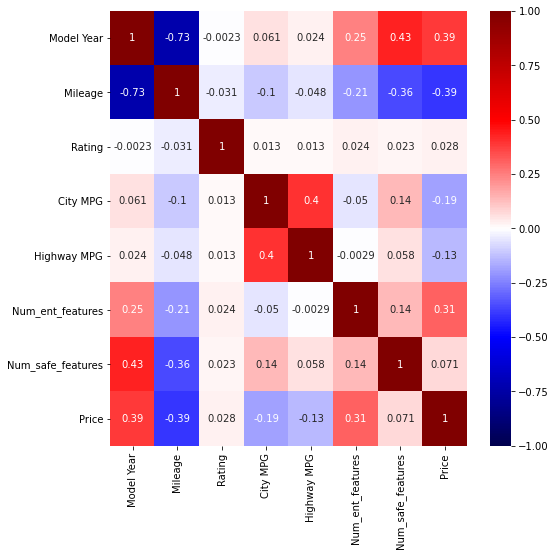

In [7]:
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(sub_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

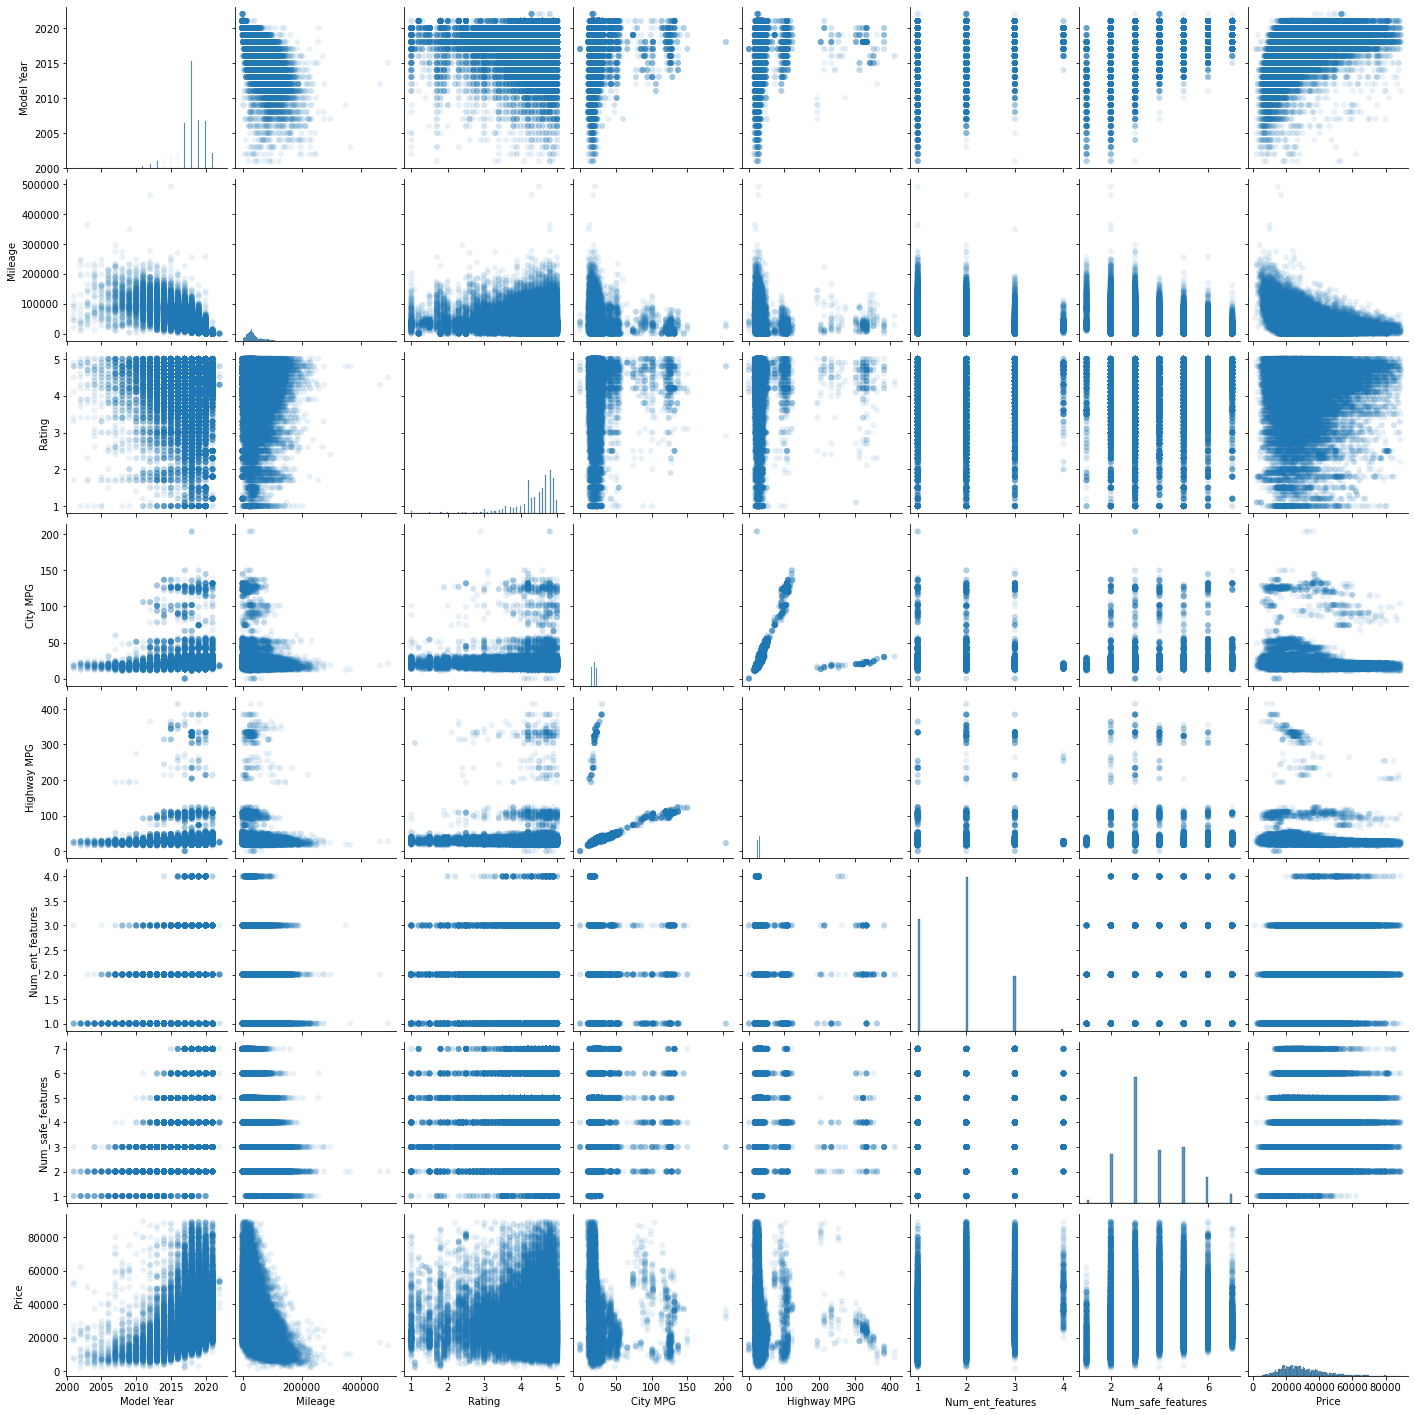

In [8]:
sns.pairplot(sub_df, plot_kws=dict(alpha=.1, edgecolor='none'))

In [9]:
X_df = sub_df[['Model Year', 'Mileage', 'Rating', 'City MPG', 'Highway MPG', 'Num_ent_features', 'Num_safe_features']]
y_df = sub_df['Price']

In [10]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
        

In [33]:
split_and_validate(X_df, y_df)


Validation R^2 score was: 0.2803521321431215
Feature coefficient results: 

Model Year : 1224.09
Mileage : -0.11
Rating : 378.66
City MPG : -205.38
Highway MPG : -47.20
Num_ent_features : 4018.92
Num_safe_features : -1140.52


In [12]:
pd.get_dummies(df.Make).head()

,Acura,Alfa Romeo,Aston Martin,Audi,BMW,Bentley,Buick,Cadillac,Chevrolet,Chrysler,...,Pontiac,Porsche,RAM,Saturn,Scion,Subaru,Tesla,Toyota,Volkswagen,Volvo
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
X1 = X_df.copy()
X1['MY2'] = X1['Model Year'] ** 2
X1['Mileage_2'] = X1['Mileage'] ** 2
split_and_validate(X1, y_df)


Validation R^2 score was: 0.2847871540104898
Feature coefficient results: 

Model Year : -174920.04
Mileage : -0.15
Rating : 404.88
City MPG : -207.06
Highway MPG : -46.48
Num_ent_features : 3930.93
Num_safe_features : -1210.67
MY2 : 43.70
Mileage_2 : 0.00


In [14]:
X2 = X1.copy()
X2['Make'] = df['Make']
split_and_validate(pd.get_dummies(X2, drop_first=True), y_df)


Validation R^2 score was: 0.5061786437627184
Feature coefficient results: 

Model Year : -312861.03
Mileage : -0.11
Rating : 286.78
City MPG : -211.27
Highway MPG : -39.31
Num_ent_features : 3384.68
Num_safe_features : -388.29
MY2 : 78.01
Mileage_2 : 0.00
Make_Alfa Romeo : -502.66
Make_Aston Martin : 44104.83
Make_Audi : 5419.16
Make_BMW : 6153.77
Make_Bentley : 42651.11
Make_Buick : -7149.78
Make_Cadillac : 4637.62
Make_Chevrolet : -644.85
Make_Chrysler : -6392.62
Make_Dodge : -2778.12
Make_FIAT : -7332.98
Make_Ford : 1644.85
Make_GMC : 5349.31
Make_Genesis : 1136.61
Make_Honda : -4183.51
Make_Hummer : 22365.33
Make_Hyundai : -8454.85
Make_INFINITI : 2011.84
Make_Jaguar : 7342.13
Make_Jeep : -495.83
Make_Kia : -8350.45
Make_Land Rover : 19219.47
Make_Lexus : 5655.58
Make_Lincoln : 1561.46
Make_MINI Cooper : -4844.84
Make_Maserati : 14036.21
Make_Mazda : -6413.91
Make_Mercedes-Benz : 7243.78
Make_Mitsubishi : -12701.65
Make_Nissan : -6708.70
Make_Other : -2063.29
Make_Pontiac : -3990.

In [15]:
df['Fuel Type'].value_counts()

 Gasoline         60249
 E85 Flex Fuel     1876
 Hybrid            1839
 Diesel            1089
 Electric           743
Name: Fuel Type, dtype: int64

In [16]:
X3 = X2.copy()

X3['Fuel Type'] = df['Fuel Type']

split_and_validate(pd.get_dummies(X3, drop_first=True), y_df)


Validation R^2 score was: 0.5839369092708331
Feature coefficient results: 

Model Year : -317888.97
Mileage : -0.11
Rating : 329.47
City MPG : -691.40
Highway MPG : -30.93
Num_ent_features : 2831.20
Num_safe_features : -278.03
MY2 : 79.29
Mileage_2 : 0.00
Make_Alfa Romeo : 600.09
Make_Aston Martin : 41998.74
Make_Audi : 5550.86
Make_BMW : 5610.98
Make_Bentley : 40490.68
Make_Buick : -6185.21
Make_Cadillac : 4436.41
Make_Chevrolet : -578.86
Make_Chrysler : -6340.19
Make_Dodge : -3633.40
Make_FIAT : -5813.60
Make_Ford : 943.94
Make_GMC : 4138.50
Make_Genesis : 294.82
Make_Honda : -1485.16
Make_Hummer : 24205.43
Make_Hyundai : -6683.18
Make_INFINITI : 1436.80
Make_Jaguar : 6644.71
Make_Jeep : -1109.15
Make_Kia : -7645.16
Make_Land Rover : 17947.45
Make_Lexus : 5747.37
Make_Lincoln : 1556.17
Make_MINI Cooper : -2935.50
Make_Maserati : 12175.04
Make_Mazda : -4326.66
Make_Mercedes-Benz : 7850.05
Make_Mitsubishi : -10827.19
Make_Nissan : -5260.99
Make_Other : -5028.29
Make_Pontiac : -3410.32

In [17]:
X4 = X3.copy()

X4[['Drivetrain', 'Engine', 'Exterior Color', 'Interior Color', 'Transmission']] = df[['Drivetrain', 'Engine', 'Exterior Color', 'Interior Color', 'Transmission']]
X4.head()

,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,MY2,Mileage_2,Make,Fuel Type,Drivetrain,Engine,Exterior Color,Interior Color,Transmission
0,2020,24371,3.5,25.0,34.0,2.0,5.0,4080400,593945641,BMW,Gasoline,AWD,2.0L,Black,Black,Automatic
2,2018,11863,3.5,22.0,28.0,2.0,6.0,4072324,140730769,Toyota,Gasoline,AWD,2.5L,Black,Black,Automatic
7,2017,10422,1.1,19.0,27.0,2.0,3.0,4068289,108618084,INFINITI,Gasoline,AWD,3.0L,Black,Graphite,Automatic
8,2017,24351,4.8,19.0,22.0,3.0,4.0,4068289,592971201,Mercedes-Benz,Gasoline,AWD,3.0L,Gray,Black,Automatic
10,2019,23152,3.9,24.0,33.0,2.0,7.0,4076361,536015104,Kia,Gasoline,FWD,2.4L,Black,Black,Automatic


In [18]:
pd.get_dummies(X4)

,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,MY2,Mileage_2,Make_Acura,...,Exterior Color_Silver,Exterior Color_White,Interior Color_Black,Interior Color_Charcoal,Interior Color_Ebony,Interior Color_Graphite,Interior Color_Gray,Interior Color_Other,Transmission_Automatic,Transmission_Manual
0,2020,24371,3.5,25.0,34.0,2.0,5.0,4080400,593945641,0,...,0,0,1,0,0,0,0,0,1,0
2,2018,11863,3.5,22.0,28.0,2.0,6.0,4072324,140730769,0,...,0,0,1,0,0,0,0,0,1,0
7,2017,10422,1.1,19.0,27.0,2.0,3.0,4068289,108618084,0,...,0,0,0,0,0,1,0,0,1,0
8,2017,24351,4.8,19.0,22.0,3.0,4.0,4068289,592971201,0,...,0,0,1,0,0,0,0,0,1,0
10,2019,23152,3.9,24.0,33.0,2.0,7.0,4076361,536015104,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101404,2017,34911,3.2,21.0,28.0,3.0,3.0,4068289,1218777921,0,...,0,1,1,0,0,0,0,0,1,0
101406,2017,46105,3.4,19.0,26.0,2.0,4.0,4068289,2125671025,0,...,0,0,1,0,0,0,0,0,1,0
101413,2017,51170,4.7,17.0,24.0,3.0,2.0,4068289,2618368900,0,...,0,0,1,0,0,0,0,0,1,0
101419,2016,127717,4.8,21.0,28.0,1.0,3.0,4064256,16311632089,0,...,0,1,1,0,0,0,0,0,1,0


In [19]:
split_and_validate(pd.get_dummies(X4), y_df)


Validation R^2 score was: 0.7810083143478377
Feature coefficient results: 

Model Year : -209615.21
Mileage : -0.13
Rating : 417.20
City MPG : -136.28
Highway MPG : -10.64
Num_ent_features : 1758.71
Num_safe_features : -51.94
MY2 : 52.44
Mileage_2 : 0.00
Make_Acura : -2288.26
Make_Alfa Romeo : 902.57
Make_Aston Martin : 29804.03
Make_Audi : 3743.72
Make_BMW : 2384.04
Make_Bentley : 30294.02
Make_Buick : -4660.08
Make_Cadillac : -1233.55
Make_Chevrolet : -5646.05
Make_Chrysler : -7508.97
Make_Dodge : -8740.29
Make_FIAT : -7264.46
Make_Ford : -3445.12
Make_GMC : -3982.45
Make_Genesis : -9235.26
Make_Honda : -2574.42
Make_Hummer : 6627.92
Make_Hyundai : -7715.53
Make_INFINITI : -4395.95
Make_Jaguar : 4217.56
Make_Jeep : -7004.83
Make_Kia : -7576.50
Make_Land Rover : 9786.00
Make_Lexus : 2210.87
Make_Lincoln : 1926.30
Make_MINI Cooper : -1121.56
Make_Maserati : 4716.66
Make_Mazda : -5811.17
Make_Mercedes-Benz : 5508.36
Make_Mitsubishi : -13460.05
Make_Nissan : -9227.44
Make_Other : -8526.

In [20]:
X5 = X4.copy()
X5['Car Model'] = df['Car Model']

In [21]:
split_and_validate(pd.get_dummies(X5), y_df)


Validation R^2 score was: 0.86182053665151
Feature coefficient results: 

Model Year : -97724.19
Mileage : -0.13
Rating : 427.32
City MPG : -78.41
Highway MPG : -7.96
Num_ent_features : 1608.48
Num_safe_features : -60.11
MY2 : 24.67
Mileage_2 : 0.00
Make_Acura : 782.86
Make_Alfa Romeo : -1284.94
Make_Aston Martin : 19044.37
Make_Audi : 32102.81
Make_BMW : -104.30
Make_Bentley : 29974.71
Make_Buick : -3037.40
Make_Cadillac : 16385.51
Make_Chevrolet : -6989.36
Make_Chrysler : -5438.33
Make_Dodge : -4780.18
Make_FIAT : -11103.50
Make_Ford : -12239.85
Make_GMC : -270.70
Make_Genesis : -3207.76
Make_Honda : -14554.78
Make_Hummer : 8173.31
Make_Hyundai : -11880.07
Make_INFINITI : -4748.08
Make_Jaguar : 3486.08
Make_Jeep : 2592.51
Make_Kia : -14245.28
Make_Land Rover : 11924.68
Make_Lexus : 9160.44
Make_Lincoln : -5870.96
Make_MINI Cooper : -6536.86
Make_Maserati : 9608.45
Make_Mazda : -7112.16
Make_Mercedes-Benz : 4540.05
Make_Mitsubishi : -10491.40
Make_Nissan : -12759.01
Make_Other : -504

In [22]:
cars = pd.get_dummies(X5, drop_first=True)

In [37]:
print(cars.shape)
cars.head()

(65796, 532)


,Model Year,Mileage,Rating,City MPG,Highway MPG,Num_ent_features,Num_safe_features,MY2,Mileage_2,Make_Alfa Romeo,...,Car Model_Yukon,Car Model_Z4,Car Model_allroad,Car Model_e-Golf,Car Model_e-tron,Car Model_i3,Car Model_i8,Car Model_iM,Car Model_tC,Car Model_xB
0,2020,24371,3.5,25.0,34.0,2.0,5.0,4080400,593945641,0,...,0,0,0,0,0,0,0,0,0,0
2,2018,11863,3.5,22.0,28.0,2.0,6.0,4072324,140730769,0,...,0,0,0,0,0,0,0,0,0,0
7,2017,10422,1.1,19.0,27.0,2.0,3.0,4068289,108618084,0,...,0,0,0,0,0,0,0,0,0,0
8,2017,24351,4.8,19.0,22.0,3.0,4.0,4068289,592971201,0,...,0,0,0,0,0,0,0,0,0,0
10,2019,23152,3.9,24.0,33.0,2.0,7.0,4076361,536015104,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(cars, y_df, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

print(X_train.shape, X_val.shape, X_test.shape)

#Train the model on train set and score on validation set
lm = LinearRegression()
lm.fit(X_train, y_train)
print(f'Linear Regression valldation R^2 score: {lm.score(X_val, y_val):.4f}')

#Run the model on the entire set
lm.fit(cars, y_df)
print(f'Linear Regression test R^2 score: {lm.score(X_test, y_test):.4f}')

(39477, 532) (13159, 532) (13160, 532)
Linear Regression valldation R^2 score: 0.8622
Linear Regression test R^2 score: 0.8656


In [65]:
#Display some of the metrics:

print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_pred)))
print('Mean Squared Error: {}'.format(mean_squared_error(y_test, y_pred)))
print('Root Mean Square Error (RMSE): {}'.format(math.sqrt(mean_squared_error(y_test, y_pred))))

Mean Absolute Error: 3415.2989893405133
Mean Squared Error: 24411662.90605356
Root Mean Square Error (RMSE): 4940.81601621165


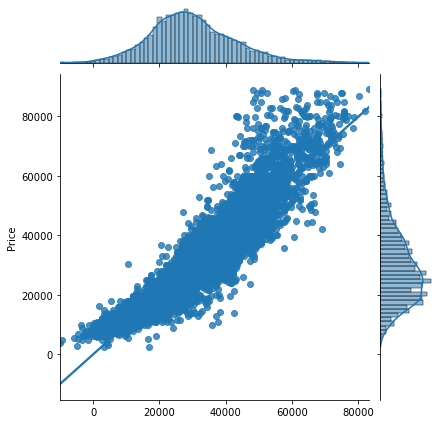

In [52]:
# kind must be one of ['scatter', 'hist', 'hex', 'kde', 'reg', 'resid']`
sns.jointplot(y_pred, y_test, kind='reg')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.show()

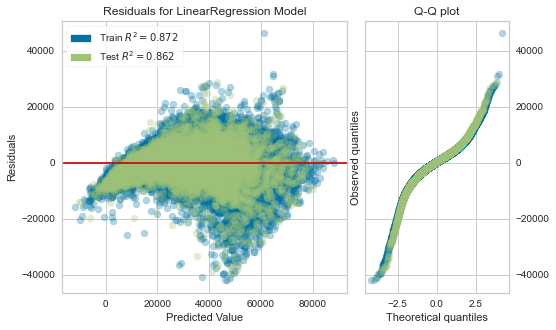

In [78]:
#!pip install yellowbrick
from yellowbrick.regressor import ResidualsPlot

#Split again 8-2
X_train, X_test, y_train, y_test = train_test_split(cars, y_df, test_size=0.2,random_state=42)

lm = LinearRegression()

plt.figure(figsize=(8,5))

res_plt = ResidualsPlot(lm, hist=False, qqplot=True, train_alpha=0.3, test_alpha=0.3, line_color='r')

res_plt.fit(X_train, y_train)  # Fit the training data to the visualizer
res_plt.score(X_test, y_test)  # Evaluate the model on the test data
res_plt.show();


In [31]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest Regression:", r2_score(y_test, y_pred))

gbm = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)
print("Gradient Boosted Regression:", r2_score(y_test, y_pred))

Random Forest Regression: 0.1164064516566734
Gradient Boosted Regression: 0.7313565540324387
